Jupyter notebook 
-------

This notebook illustrates the codes used to select biomarkers by Boruta algorithm in the paper **"Data independent acquisition mass spectrometry in severe Rheumatic Heart Disease (RHD) identifies a proteomic signature showing ongoing inflammation and effectively classifying RHD cases"**

Author: **Jing Yang**

Date: **17/11/2021**

Contact: Jing.Yang@manchester.ac.uk

In [1]:
library(caret)
library(data.table)
library(tidyverse)
library(Boruta)
library(DescTools)

Loading required package: ggplot2

Loading required package: lattice

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::lift()      masks caret::lift()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘DescTools’


The following object is masked from ‘package:data.table’:

    %like%


The following objects are masked from ‘package:caret’:

    MAE, RMSE




In [2]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.7 LTS

Matrix products: default
BLAS:   /usr/lib/openblas-base/libblas.so.3
LAPACK: /usr/lib/libopenblasp-r0.2.18.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DescTools_0.99.43 Boruta_7.0.0      forcats_0.5.1     stringr_1.4.0    
 [5] dplyr_1.0.7       purrr_0.3.4       readr_2.0.2       tidyr_1.1.4      
 [9] tibble_3.1.5      tidyverse_1.3.1   data.table_1.14.2 caret_6.0-89     
[13] lattice_0.20-45   ggplot2_3.3.5    

loaded via a namespace (an

### read log2 scaled protein expression data

In [3]:
data <- read.csv(file='Data/RHD_data_filtered.csv')

In [4]:
head(data)

,StollerID,A5YKK6,B9A064,O00187,O00391,O00429,O00533,O14556,O14791,O14980,⋯,Q9UQ35,Q9Y2S2,Q9Y2Z0,Q9Y446,Q9Y490,Q9Y4L1,Q9Y5Y7,Q9Y6R7,Q9Y6U3,Group
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,RHD01_1,18.72726,13.32757,9.545403,10.93532,NA,9.693684,10.765847,13.54541,14.28571,⋯,NA,16.33353,17.04409,13.99638,18.55010,10.78719,11.558106,NA,16.02570,Case
2,RHD01_10,17.09342,11.99219,11.119640,11.36314,12.65523,NA,11.287226,13.51076,NA,⋯,NA,NA,15.68102,14.41961,18.27449,11.17612,NA,17.57590,15.99541,Control
3,RHD01_100,NA,16.99410,9.841260,12.05345,13.49063,10.120308,9.788836,13.07768,15.63010,⋯,NA,16.21441,14.98246,15.27436,18.64911,11.67593,9.798376,18.05495,15.21582,Control
4,RHD01_101,NA,11.05973,10.855083,11.52179,14.05859,10.599453,10.542719,13.98480,15.74108,⋯,10.031960,16.51174,NA,NA,19.14743,12.67218,10.626237,NA,16.07679,Control
5,RHD01_102,18.01907,14.42647,NA,12.03946,13.58525,10.212223,10.447536,14.15161,15.58056,⋯,9.875406,16.80517,NA,15.85524,18.39157,11.65981,11.531890,19.18588,16.05441,Control
6,RHD01_103,17.32733,14.57000,10.600376,12.43219,13.43931,10.531699,10.678076,13.50614,14.92608,⋯,10.815293,16.79194,NA,15.80052,19.43061,11.51000,11.223427,NA,16.29087,Control


In [5]:
data[is.na(data)] <- 0

### Divide the data to training (70%) and testing data(30%) and start boruta algorithm

In [6]:
set.seed(1)
trainIndex <- createDataPartition(data$Group, p=0.7, list=FALSE)
trainingData <- data[trainIndex,]
testData <- data[-trainIndex,]
Boruta.allsample <- Boruta(Group ~ ., data =trainingData, ntree = 500, maxRuns=4000)
##load(file='Data/Boruta_results_2108.RData') 


### Extract the results

In [7]:
result_allsample <- attStats(Boruta.allsample) %>% filter(decision %in% 'Confirmed')  %>% 
mutate(UniProtID=rownames(.)) %>% arrange(desc(medianImp))

proteins_confirmed <- result_allsample$UniProtID


In [8]:
importance_history <- Boruta.allsample$ImpHistory
imp_boruta <- importance_history[,colnames(Boruta.allsample$ImpHistory) %in% proteins_confirmed]
sorted_proteins_boruta <- names(sort(-apply(imp_boruta,2,mean)))
imp_boruta_forplot <- as_tibble(imp_boruta) %>% mutate(label=1:dim(imp_boruta)[1]) %>% gather(UniProtID, value, -label)
imp_boruta_forplot$UniProtID <- factor(imp_boruta_forplot$UniProtID, levels=sorted_proteins_boruta)

### Plots of permutation importance for biomarkers from Boruta

In [9]:
protein_withname <- fread('Data/protein_withname.txt')

In [10]:
proteinname_confirmed <- left_join(data.frame(UniProtID=proteins_confirmed), protein_withname) %>% pull(ProteinName)

Joining, by = "UniProtID"



In [11]:
imp_boruta_forplot_withname <- left_join(imp_boruta_forplot, protein_withname)

Joining, by = "UniProtID"



In [12]:
imp_boruta_forplot_withname$ProteinName <- factor(imp_boruta_forplot_withname$ProteinName, levels=proteinname_confirmed)

### Generating Fig. 1a

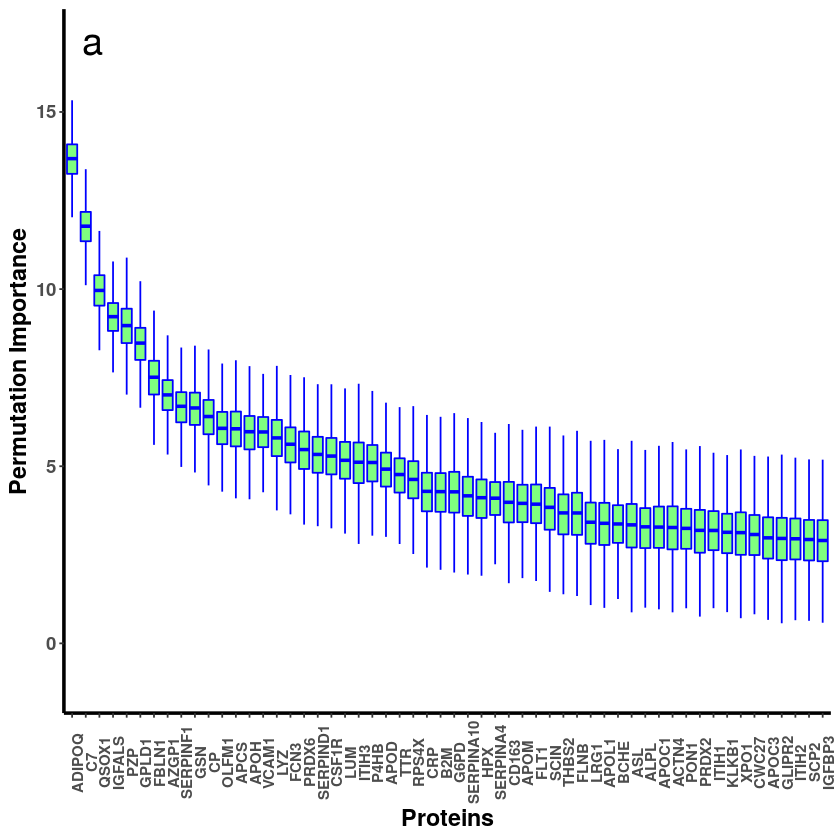

In [13]:
ggplot(imp_boruta_forplot_withname, aes(x=ProteinName, y=value)) + geom_boxplot(alpha=0.5, outlier.shape=NA, fill='green', color='blue') + #coord_flip() +
ylab('Permutation Importance') + xlab('Proteins') + annotate("text", x = 2.5, y = 17, label = "a", size=8) + 
theme(panel.background=element_blank(),#panel.background=element_rect(fill='white',color='black',linetype=1), 
      #panel.grid.major=element_line(color='grey', size=0.1), 
     axis.line=element_line(size=1),text=element_text(size=14, face="bold"),
      axis.text.x=element_text(size=9, angle=90, face='bold'), axis.title=element_text(size=14, face="bold"),
      strip.text.x=element_blank(),strip.text.y=element_blank(), strip.background=element_blank())